# Klasifikacija zdravlja fetusa na temelju kardiotokograma

### Autori: Valentina Križ, Jelena Kurilić, Lucija Valentić

Ovaj jupyter notebook napravljen je za potrebe kolegija Strojno učenje na PMF-u Sveučilišta u Zagrebu. 

Mentori: <br>
&nbsp;&nbsp; - Tomislav Šmuc, prof. <br>
&nbsp;&nbsp; - Matija Piškorec, asist. <br>
&nbsp;&nbsp; - Tomislav Lipić, asist. <br>

U ovom notebook-u prikazana je realizacija dijela projekta u kojemu pronalazimo najbolje klasifikatore za zdravlje fetusa. <br>
Koristimo UCI <i>Cardiotocography dataset</i> koji je moguće preuzeti na [1].

### 1. Dataset

Naš dataset se sastoji od 2126 primjeraka dobivenih automatskom obradom kardiotokograma koji su raspoređeni u 3 klase - Normal (N), Suspect (S) i Pathologic (P). <br>
Svaki primjerak je opisan pomoću 21 značajke. <br>
Eksploratornom analizom je zaključeno da se radi o medicinskom <b>nebalansiranom klasifikacijskom problemu</b>, stoga je u ovom radu naglasak na odabiru modela (i oversampling metode) koji će uspješno klasificirati patološke slučajeve. 

### 2. Učitavanje podataka

Za treniranje modela korišten je poseban jupyter notebook u kojemo je napravljena podjela na stratificirane train i test skupove. Stratifikacijom smo osigurale da svaki podskup bude dobra reprezentacija cijelog skupa podataka, tj. osiguran je isti omjer klasa u sva tri skupa. <br>
Prilikom eksploratorne analize utvrdile smo da postoji jaka koreliranost između značajki <i>Min</i> i <i>Width</i> (negativna koreliranost -0.89), te <i>Mean</i> i <i>Median</i> (pozitivna koreliranost 0.94). U slučaju jake koreliranosti dviju varijabli, preporuča se izbaciti jednu od njih [3]. Budući da su <i>Mean</i> i <i>Width</i> jače korelirane s ciljnom varijablom, odlučile smo izbaciti značajke <i>Min</i> i <i>Median</i>.

In [43]:
#import potrebnih biblioteka
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#imena stupaca u CTG.xls koje ćemo koristiti
column_names = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Max',
                   'Nmax', 'Nzeros', 'Mode', 'Mean', 'Variance', 'Tendency', 'NSP']

#stupci koji sadrže int vrijednosti, samo za ljepši ispis
int_columns = ['LB', 'ASTV', 'ALTV', 'Width', 'Max', 'Nmax', 'Nzeros','Mode', 'Mean', 'Variance',
               'Tendency', 'NSP']

In [34]:
data = pd.read_excel('CTG.xls', sheet_name = 'Data', skiprows = 1, 
                     usecols = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 45]
                     , names = column_names)

#izbacujemo sve retke u kojima je barem jedna varijabla nepoznata (NaN)
data = data.dropna()

for col in int_columns:
    data[col] = (data[col]).astype(int)

In [35]:
names = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Max',
                   'Nmax', 'Nzeros', 'Mode', 'Mean', 'Variance', 'Tendency']
X_train = pd.read_csv('X_train.csv', names = names, header = None)
X_test = pd.read_csv('X_test.csv', names = names, header = None)
y_train = pd.read_csv('y_train.csv', names = ['NSP'], header = None)
y_test = pd.read_csv('y_test.csv', names = ['NSP'], header = None)

### 3. Testiranje modela

Svi testirani modeli učitani su iz <i>pickle</i> datoteka koje su nastale prilikom treniranja u treniranje.ipynb. <br>
Usporedile smo sljedeće algoritme strojnog učenja: SVC (Support Vector Classification), XGBoost (Extreme Gradient Boosting) i Random Forest. Za svaki navedeni algoritam dobile smo 4 različita modela - bez oversamplinga i uz 3 različite metode oversamplinga (SMOTE, BorderlineSMOTE i ADASYN). <br><br>
Optimalni parametri modela određeni su pomoću GridSearchCV-a. Za XGBoost optimizirale smo sljedeće parametre: min_child_weight ϵ {1, 5, 10}, gamma ϵ {0.5, 1, 1.5, 2, 5}, subsample ϵ {0.6, 0.8, 1.0}, colsample_bytree ϵ {0.6, 0.8, 1.0} i max_depth ϵ {3, 4, 5}. Optimizirani parametri za Random forest su n_estimators ϵ {16, 32, 64, 128} i max_features ϵ {1, 2, 3, …, 19}. Za SVC optimizirale smo parametar c ϵ {1, 10, 100, 1000} uz linear kernel, te parametre c ϵ {1, 10, 100, 1000} i gamma ϵ {0.001, 0.0001} uz rbf kernel. <br><br>
Za svaki od modela odredile smo točnost i preciznost (omjer broja prepoznatih patoloških primjeraka i ukupnog broja patoloških primjeraka) na test skupu. <br><br>
Za treniranje i testiranje modela potrebno je instalirati imbalanced-learn [2] i XGBoost [4].

<b>SVC:</b>

In [148]:
with open('svc_SMOTE.pkl', 'rb') as file:  
    svc_SMOTE = pickle.load(file)
with open('svc_BorderlineSMOTE.pkl', 'rb') as file:  
    svc_BorderlineSMOTE = pickle.load(file)
with open('svc_ADASYN.pkl', 'rb') as file:  
    svc_ADASYN = pickle.load(file)
with open('svc.pkl', 'rb') as file:  
    svc_obicni = pickle.load(file)

print("Točnost SVC bez oversamplinga: %.4f" %svc_obicni.score(X_test, y_test))
print("Osjetljivost SVC bez oversamplinga: %.4f" %recall_score(y_test, svc_obicni.predict(X_test), average = None)[2])

print("Točnost SVC uz SMOTE: %.4f" %svc_SMOTE.score(X_test, y_test))
print("Osjetljivost SVC uz SMOTE: %.4f" %recall_score(y_test, svc_SMOTE.predict(X_test), average = None)[2])

print("Točnost SVC uz BorderlineSMOTE: %.4f" %svc_BorderlineSMOTE.score(X_test, y_test))
print("Osjetljivost SVC uz BorderlineSMOTE: %.4f" %recall_score(y_test, svc_BorderlineSMOTE.predict(X_test), average = None)[2])

print("Točnost SVC uz ADASYN: %.4f" %svc_ADASYN.score(X_test, y_test))
print("Osjetljivost SVC uz ADASYN: %.4f" %recall_score(y_test, svc_ADASYN.predict(X_test), average = None)[2])

Točnost SVC bez oversamplinga: 0.9061
Osjetljivost SVC bez oversamplinga: 0.7429
Točnost SVC uz SMOTE: 0.8920
Osjetljivost SVC uz SMOTE: 0.8857
Točnost SVC uz BorderlineSMOTE: 0.8592
Osjetljivost SVC uz BorderlineSMOTE: 0.8571
Točnost SVC uz ADASYN: 0.8732
Osjetljivost SVC uz ADASYN: 0.9143


<b>XGBoost:</b>

In [149]:
with open('xgb_SMOTE.pkl', 'rb') as file:  
    xgb_SMOTE = pickle.load(file)
with open('xgb_BorderlineSMOTE.pkl', 'rb') as file:  
    xgb_BorderlineSMOTE = pickle.load(file)
with open('xgb_ADASYN.pkl', 'rb') as file:  
    xgb_ADASYN = pickle.load(file)
with open('xgb.pkl', 'rb') as file:  
    xgb_obicni = pickle.load(file)

print("Točnost xgBoost bez oversamplinga: %.4f" %xgb_obicni.score(X_test.values, y_test.values))
print("Osjetljivost xgBoost bez oversamplinga: %.4f" %recall_score(y_test.values, xgb_obicni.predict(X_test.values), average = None)[2])

print("Točnost xgBoost uz SMOTE: %.4f" %xgb_SMOTE.score(X_test.values, y_test.values))
print("Osjetljivost xgBoost uz SMOTE: %.4f" %recall_score(y_test.values, xgb_SMOTE.predict(X_test.values), average = None)[2])

print("Točnost xgBoost uz BorderlineSMOTE: %.4f" %xgb_BorderlineSMOTE.score(X_test.values, y_test.values))
print("Osjetljivost xgBoost uz BorderlineSMOTE: %.4f" %recall_score(y_test.values, xgb_BorderlineSMOTE.predict(X_test.values), average = None)[2])

print("Točnost xgBoost uz ADASYN: %.4f" %xgb_ADASYN.score(X_test.values, y_test.values))
print("Osjetljivost xgBoost uz ADASYN: %.4f" %recall_score(y_test.values, xgb_ADASYN.predict(X_test.values), average = None)[2])

Točnost xgBoost bez oversamplinga: 0.9343
Osjetljivost xgBoost bez oversamplinga: 0.9143
Točnost xgBoost uz SMOTE: 0.9319
Osjetljivost xgBoost uz SMOTE: 0.9143
Točnost xgBoost uz BorderlineSMOTE: 0.9413
Osjetljivost xgBoost uz BorderlineSMOTE: 0.9143
Točnost xgBoost uz ADASYN: 0.9366
Osjetljivost xgBoost uz ADASYN: 0.9429


<b>Random Forest:</b>

In [150]:
with open('rf_SMOTE.pkl', 'rb') as file:  
    rf_SMOTE = pickle.load(file)
with open('rf_BorderlineSMOTE.pkl', 'rb') as file:  
    rf_BorderlineSMOTE = pickle.load(file)
with open('rf_ADASYN.pkl', 'rb') as file:  
    rf_ADASYN = pickle.load(file)
with open('rf.pkl', 'rb') as file:  
    rf_obicni = pickle.load(file)

print("Točnost Random forest bez oversamplinga: %.4f" %rf_obicni.score(X_test, y_test))
print("Osjetljivost Random forest bez oversamplinga: %.4f" %recall_score(y_test, rf_obicni.predict(X_test), average = None)[2])

print("Točnost Random forest uz SMOTE: %.4f" %rf_SMOTE.score(X_test, y_test))
print("Osjetljivost Random forest uz SMOTE: %.4f" %recall_score(y_test, rf_SMOTE.predict(X_test), average = None)[2])

print("Točnost Random forest uz BorderlineSMOTE: %.4f" %rf_BorderlineSMOTE.score(X_test, y_test))
print("Osjetljivost Random forest uz BorderlineSMOTE: %.4f" %recall_score(y_test, rf_BorderlineSMOTE.predict(X_test), average = None)[2])

print("Točnost Random forest uz ADASYN: %.4f" %rf_ADASYN.score(X_test, y_test))
print("Osjetljivost Random forest uz ADASYN: %.4f" %recall_score(y_test, rf_ADASYN.predict(X_test), average = None)[2])

Točnost Random forest bez oversamplinga: 0.9249
Osjetljivost Random forest bez oversamplinga: 0.8571
Točnost Random forest uz SMOTE: 0.9225
Osjetljivost Random forest uz SMOTE: 0.8571
Točnost Random forest uz BorderlineSMOTE: 0.9319
Osjetljivost Random forest uz BorderlineSMOTE: 0.9143
Točnost Random forest uz ADASYN: 0.9225
Osjetljivost Random forest uz ADASYN: 0.9143


### 4. Prikaz rezultata

Za svaki od algoritama prikazale smo konfuzijske matrice koje predstavljaju rezultate dobivene modelom bez oversamplinga, te modelom uz oversampling metodu koja je dala najbolje rezultate za taj algoritam. <br>Konkretno, prikazale smo konfuzijske matrice za: <br>
&nbsp; &nbsp; - SVC bez oversamplinga i SVC uz ADASYN oversampling <br>
&nbsp; &nbsp; - XGBoost bez oversamplinga i XGBoost uz ADASYN oversampling <br>
&nbsp; &nbsp; - Random Forest bez oversamplinga i Random Forest uz BorderlineSMOTE oversampling <br><br>
Konačno, odredile smo najvažnije značajke u XGBoost modelu uz ADASYN i Random Forest modelu uz BorderlineSMOTE. Dobivene značajke pokazale su se bitnima za zdravlje fetusa i u mnogim medicinskim radovima.

<b>SVC:</b>

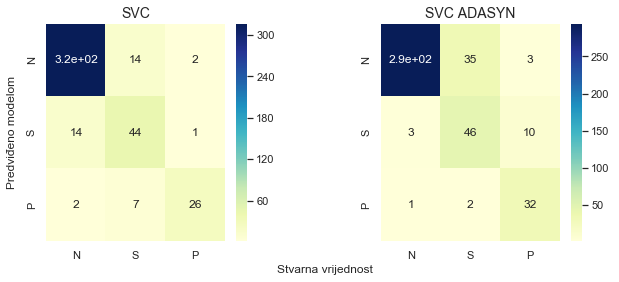

In [158]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(wspace=0.5, hspace=0.2)
ax = fig.add_subplot(111)  
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_facecolor('white')

svc_cm = confusion_matrix(y_test, svc_obicni.predict(X_test))
svc_ADASYN_cm = confusion_matrix(y_test, svc_ADASYN.predict(X_test))

label = ["N","S","P"]
sns.set(font_scale=1.0)
ax1.set_title('SVC', fontsize = 14)
ax2.set_title('SVC ADASYN', fontsize = 14)
ax.set_xlabel('Stvarna vrijednost')
ax.set_ylabel('Predviđeno modelom')

sns.heatmap(svc_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax1)
sns.heatmap(svc_ADASYN_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax2)

plt.show()

<b>XGBoost:</b>

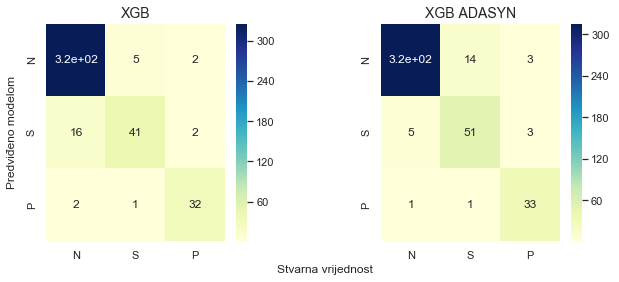

In [159]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(wspace=0.5, hspace=0.2)
ax = fig.add_subplot(111)  
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xgb_cm = confusion_matrix(y_test.values, xgb_obicni.predict(X_test.values))
xgb_ADASYN_cm = confusion_matrix(y_test.values, xgb_ADASYN.predict(X_test.values))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_facecolor('white')

ax1.set_title('XGB', fontsize = 14)
ax2.set_title('XGB ADASYN', fontsize = 14)
label = ["N","S","P"]
ax.set_xlabel('Stvarna vrijednost')
ax.set_ylabel('Predviđeno modelom')
sns.heatmap(xgb_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax1)
sns.heatmap(xgb_ADASYN_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax2)

plt.show()

<b>Random forest:</b>

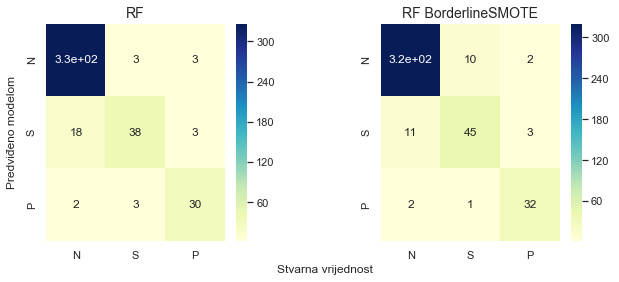

In [160]:
fig = plt.figure(figsize=[10, 4])  
fig.subplots_adjust(wspace=0.5, hspace=0.2)
ax = fig.add_subplot(111) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

rf_cm = confusion_matrix(y_test, rf_obicni.predict(X_test))
rf_BorderlineSMOTE_cm = confusion_matrix(y_test, rf_BorderlineSMOTE.predict(X_test))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_facecolor('white')

ax1.set_title('RF', fontsize = 14)
ax2.set_title('RF BorderlineSMOTE', fontsize = 14)
label = ["N","S","P"]
ax.set_xlabel('Stvarna vrijednost')
ax.set_ylabel('Predviđeno modelom')
sns.heatmap(rf_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax1)
sns.heatmap(rf_BorderlineSMOTE_cm, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu", ax=ax2)

plt.show()

<Figure size 720x360 with 0 Axes>

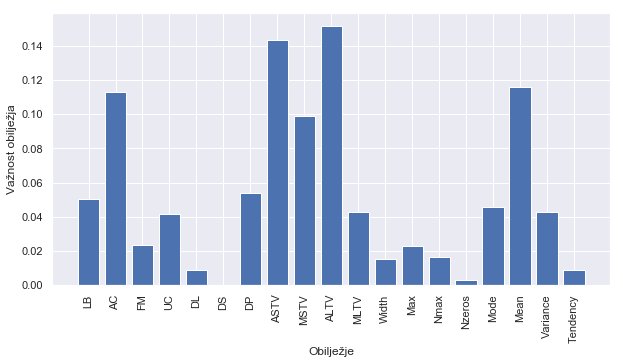

In [161]:
fig = plt.figure(figsize=(10,5))
importances = {}
imp = rf_BorderlineSMOTE.named_steps["classification"].feature_importances_
for i in range(19):
    importances[column_names[i]] = imp[i]
fig = plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), list(importances.values()), align='center')
plt.xticks(range(len(importances)), list(importances.keys()), rotation='vertical')
plt.xlabel('Obilježje')
plt.ylabel('Važnost obilježja')
plt.show()

<Figure size 720x360 with 0 Axes>

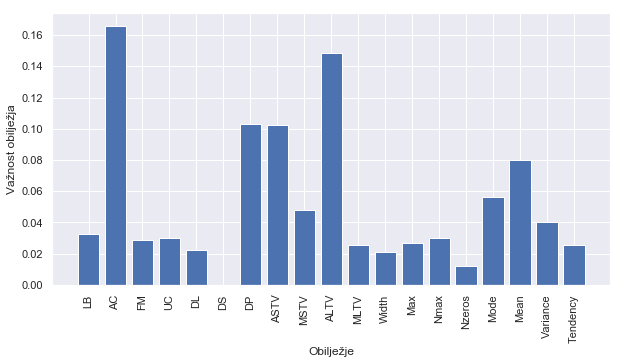

In [162]:
fig = plt.figure(figsize=(10,5))
importances = {}
imp = xgb_ADASYN.named_steps["classification"].feature_importances_
for i in range(19):
    importances[column_names[i]] = imp[i]
fig = plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), list(importances.values()), align='center')
plt.xticks(range(len(importances)), list(importances.keys()), rotation='vertical')
plt.xlabel('Obilježje')
plt.ylabel('Važnost obilježja')
plt.show()

### Literatura

[1] https://archive.ics.uci.edu/ml/datasets/cardiotocography <br>
[2] https://imbalanced-learn.readthedocs.io/en/stable/ <br>
[3] https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf <br>
[4] https://xgboost.readthedocs.io/en/latest/